In [48]:
%matplotlib inline
import random

import cv2
from matplotlib import pyplot as plt

In [78]:
import os
from multiprocessing.dummy import freeze_support
from pathlib import Path
import albumentations as A
import cv2
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map, thread_map
import numpy as np

from scrapper.util.io import json_load

anno, img = (Path(f'F:/workspace/datasets/DeepFashion2 Dataset/train/annos/000001.json'),
             Path(f'F:/workspace/datasets/DeepFashion2 Dataset/train/image/000001.jpg'))

from multiprocessing import RLock

tqdm.set_lock(RLock())


def list_anno_img_paths(anno_path, img_path, IGNORE_CHECK=False):
    annos = os.listdir(anno_path)
    annos_len = len(annos)

    imgs = map(lambda x: x.split(".json")[0] + ".jpg", annos)

    annos = list(map(lambda x: Path(anno_path, x), annos))
    imgs = list(map(lambda x: Path(img_path, x), imgs))

    if not IGNORE_CHECK:
        imgs_itter = tqdm(imgs, desc="IMG::exists", total=annos_len)

        img_missing = any(filter(lambda i: not i.exists(), imgs_itter))
        assert not img_missing, "Atleast one Image missing"

    return list(zip(annos, imgs))


def load_items(anno_path):
    anno_data = json_load(anno_path)
    item_keys = filter(lambda i: "item" in i, anno_data.keys())
    items = map(lambda k: anno_data[k], item_keys)

    return list(items)


def clean_bbox(bbox, width, height):
    x_min, y_min, x_max, y_max = bbox   
    
    return [max(x_min/width, 0.0), 
            max(y_min/height, 0.0), 
            min(x_max/width, 1.0), 
            min(y_max/height, 1.0)] 
#coco: [x_min, y_min, width, height]#albumentations/voc [x_min, y_min, x_max, y_max] <- (0, 1)


###
####    width = x_max - x_min
####    height = y_max - y_min
###return x_min, y_min, width, height


def clean_bboxes(bboxes, width, height):
    return list(map(lambda bb: clean_bbox(bb, width, height), bboxes))


def categories():
    return [{'id': 1, 'name': 'short_sleeved_shirt', 'supercategory': 'clothes'},
            {'id': 2, 'name': 'long_sleeved_shirt', 'supercategory': 'clothes'},
            {'id': 3, 'name': 'short_sleeved_outwear', 'supercategory': 'clothes'},
            {'id': 4, 'name': 'long_sleeved_outwear', 'supercategory': 'clothes'},
            {'id': 5, 'name': 'vest', 'supercategory': 'clothes'},
            {'id': 6, 'name': 'sling', 'supercategory': 'clothes'},
            {'id': 7, 'name': 'shorts', 'supercategory': 'clothes'},
            {'id': 8, 'name': 'trousers', 'supercategory': 'clothes'},
            {'id': 9, 'name': 'skirt', 'supercategory': 'clothes'},
            {'id': 10, 'name': 'short_sleeved_dress', 'supercategory': 'clothes'},
            {'id': 11, 'name': 'long_sleeved_dress', 'supercategory': 'clothes'},
            {'id': 12, 'name': 'vest_dress', 'supercategory': 'clothes'},
            {'id': 13, 'name': 'sling_dress', 'supercategory': 'clothes'}]


def category_id_to_name():
    return {1: 'short_sleeved_shirt',
            2: 'long_sleeved_shirt',
            3: 'short_sleeved_outwear',
            4: 'long_sleeved_outwear',
            5: 'vest',
            6: 'sling',
            7: 'shorts',
            8: 'trousers',
            9: 'skirt',
            10: 'short_sleeved_dress',
            11: 'long_sleeved_dress',
            12: 'vest_dress',
            13: 'sling_dress'}


def load_img(path):
    image = cv2.imread(str(path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def transform_image_bounding_box(annotation_path, image_path, transformer):
    img = (load_img(image_path))
    height, width, channels = img.shape

    anno_items = load_items(annotation_path)

    bboxes = map(lambda i: i["bounding_box"], anno_items)
    bboxes = clean_bboxes(bboxes, width, height)

    category_ids = map(lambda i: i["category_id"], anno_items)
    category_ids = list(category_ids)

    category_names = map(lambda i: i["category_name"], anno_items)
    category_names = list(category_names)

    return transformer(image=load_img(image_path), bboxes=bboxes, class_labels=category_ids,
                       class_categories=category_names)


def transform_w_bb(transformer):
    def __call__(d):
        return transform_image_bounding_box(d[0], d[1], transformer)

    return __call__


def calc_chunksize(n_workers, len_iterable, factor=4):
    """
    SRC: https://stackoverflow.com/a/54032744
    Calculate chunksize argument for Pool-methods.

    Resembles source-code within `multiprocessing.pool.Pool._map_async`.
    """
    chunksize, extra = divmod(len_iterable, n_workers * factor)
    if extra:
        chunksize += 1
    return chunksize


if __name__ == '__main__':
    freeze_support()

    transform = A.Compose([
        A.Resize(width=256, height=256),
        A.RandomCrop(width=244, height=244),
        #    A.HorizontalFlip(p=0.5),
        #    A.RandomBrightnessContrast(p=0.2),
    ], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels', 'class_categories'],  # coco
                                min_area=1024, min_visibility=0.1, ))

    anno_path, img_path = (Path(f'F:/workspace/datasets/DeepFashion2 Dataset/train/annos'),
                           Path(f'F:/workspace/datasets/DeepFashion2 Dataset/train/image'))

    anno_imgs = list_anno_img_paths(anno_path, img_path, IGNORE_CHECK=True)


In [79]:
anno_imgs = [(Path('F:/workspace/datasets/DeepFashion2 Dataset/train/annos/000001.json'),
  Path('F:/workspace/datasets/DeepFashion2 Dataset/train/image/000001.jpg')),
 (Path('F:/workspace/datasets/DeepFashion2 Dataset/train/annos/028225.json'),
  Path('F:/workspace/datasets/DeepFashion2 Dataset/train/image/028225.jpg'))]

transformed_list = list(map(transform_w_bb(transform), anno_imgs))

In [106]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, w, h, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    
    x_min, x_max = x_min*w, x_max*w
    y_min, y_max = y_min*h, y_max*h
    
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    h, w, c = image.shape
    
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name, w=w, h=h)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

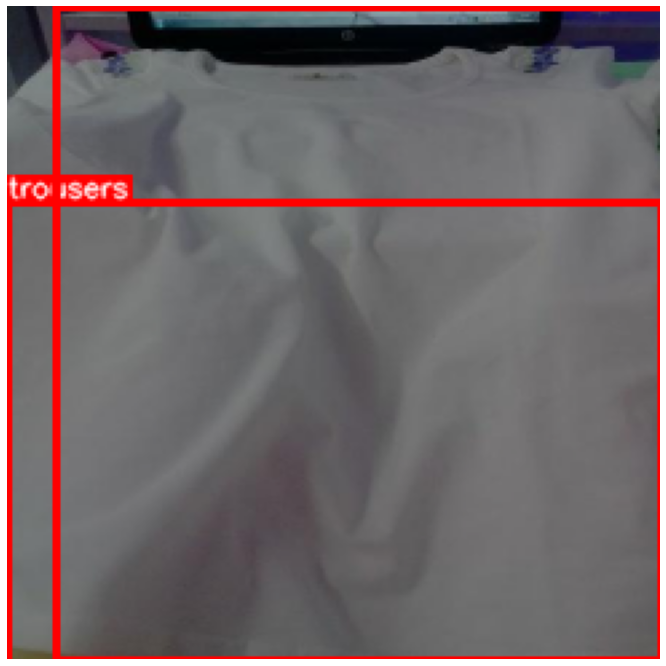

In [107]:
current = transformed_list[1]
visualize(current["image"], current["bboxes"], current["class_labels"], cat_id_to_name)